In [20]:
import scipy.io
math_path = r"C:\Users\gia19\OneDrive\Documentos\RepositorioCacahuate\Parcial 2\Coactivation_matrix.mat"
contents = scipy.io.loadmat(math_path)
coactivation_matrix = contents["Coactivation_matrix"]
coord = contents["Coord"]
coactivation_matrix.shape, coord.shape

((638, 638), (638, 3))

### Ejercicio 1
Definir grafos con la matriz estableciendo umbrales de coactivación de 0.8, 0.9 y 1
y graficar cada grafo. Añadir las coordenadas tridimensionales

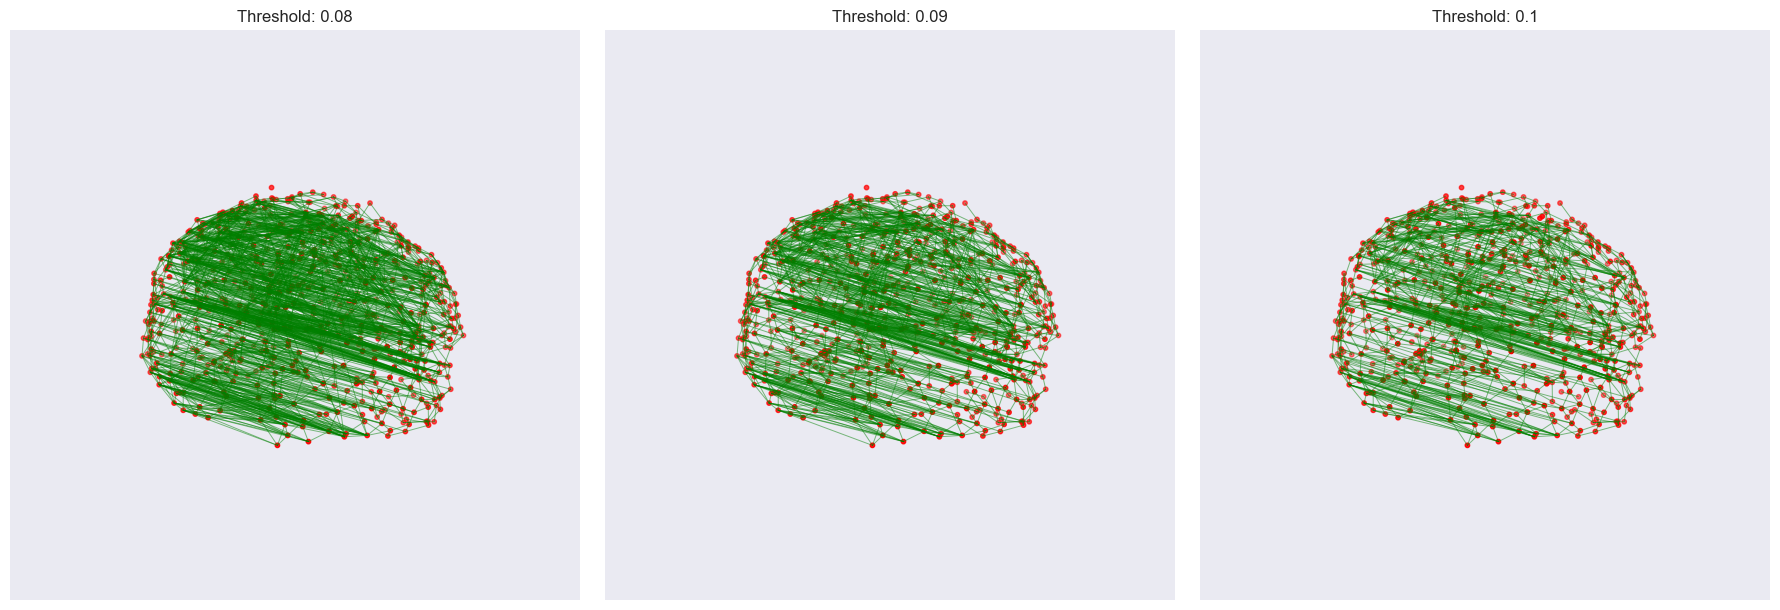

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


def haciendo_grafo(matrix, coords, threshold, ax):
    adjacency_matrix = (matrix>=threshold).astype(int)
    
    G = nx.from_numpy_array(adjacency_matrix)
    # Graficar en 3D
    ax.set_title(f"Threshold: {threshold}")
    ax.axis("off")
    for edge in G.edges():
        x_vals = [coords[edge[0], 0], coords[edge[1], 0]]
        y_vals = [coords[edge[0], 1], coords[edge[1], 1]]
        z_vals = [coords[edge[0], 2], coords[edge[1], 2]]
        ax.plot(x_vals, y_vals, z_vals, c='g', alpha=0.5, linewidth=0.7)
    
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='r', s=10)

fig = plt.figure(figsize=(18, 6))

thresholds = [0.08, 0.09, 0.1]

for i, threshold in enumerate(thresholds, 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    haciendo_grafo(coactivation_matrix, coord, threshold, ax)

plt.tight_layout()
plt.show()

### Ejercicio 2
Con uno de los grafos en el punto uno con umbral 0.9, generar una animación
donde se haga girar 360° el grafo del cerebro para visualizar las conexiones
establecidas.

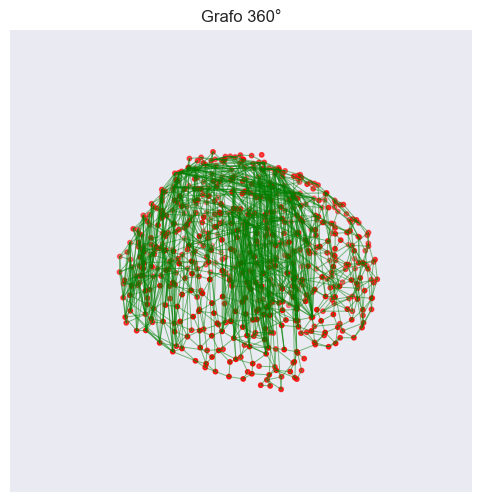

In [29]:
from matplotlib.animation import FuncAnimation

def update_rotation(frame, graph, coords, ax):
    ax.cla()  # Limpiar el eje
    ax.set_title("Grafo 360°")
    ax.axis("off")
    for edge in graph.edges():
        x_vals = [coords[edge[0], 0], coords[edge[1], 0]]
        y_vals = [coords[edge[0], 1], coords[edge[1], 1]]
        z_vals = [coords[edge[0], 2], coords[edge[1], 2]]
        ax.plot(x_vals, y_vals, z_vals, c='g', alpha=0.5, linewidth=0.7)
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='r', s=10)
    ax.view_init(30, frame)  # Cambiar el ángulo de vista

# Grafo para el umbral de 0.09
adjacency_matrix_09 = (coactivation_matrix >= 0.09).astype(int)
graph_09 = nx.from_numpy_array(adjacency_matrix_09)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

anim = FuncAnimation(fig, update_rotation, frames=360, fargs=(graph_09, coord, ax), interval=50)


### Ejercicio 3
Encontrar los hubs del grafo, y establecer el tamaño del nodo proporcional al valor
del grado.

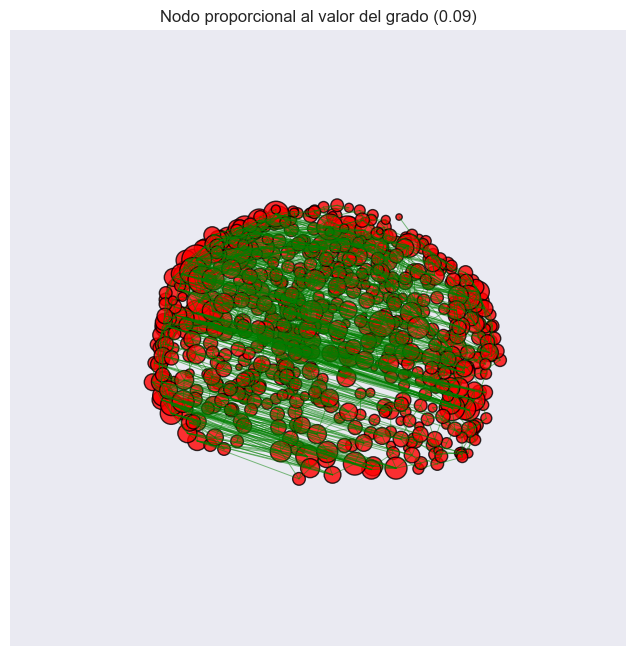

In [32]:
# XQ USAR graph_09 EN LUGAR DEL GRAFO COMPLETO?

# NO HUBO CÁLCULO DE HUBS. hub = grado arriba de media +una desviación estandar
degrees = dict(graph_09.degree())

max_degree = max(degrees.values())
node_sizes = [500 * (deg / max_degree) for deg in degrees.values()]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Para las aristas:
for edge in graph_09.edges():
    x_vals = [coord[edge[0], 0], coord[edge[1], 0]]
    y_vals = [coord[edge[0], 1], coord[edge[1], 1]]
    z_vals = [coord[edge[0], 2], coord[edge[1], 2]]
    ax.plot(x_vals, y_vals, z_vals, c='g', alpha=0.5, linewidth=0.7)

ax.scatter(
    coord[:, 0], coord[:, 1], coord[:, 2],
    c='r', s=node_sizes, alpha=0.8, edgecolors='k'
)

ax.set_title("Nodo proporcional al valor del grado (0.09)")
ax.axis("off")

plt.show()

### Ejercicio 4
En función de la matriz de emparejamiento (correlación de la matriz de
adyacencia), establecer una partición de los nodos en módulos. Escoger el número
de módulos que creas conveniente y justificar por qué escogiste ese número.

In [33]:
from sklearn.cluster import SpectralClustering

graph = nx.from_numpy_array(coactivation_matrix)
# Rango de 2 a 10 módulos, esto evaluando la modularidad, para saber que tan bien separados están los módulos dentro de una red, estos números aseguran que los módulos capturan una estructura coherente en la red sin fragmentarla 
range_clusters = range(2, 11)
modularity_scores = []
best_partition = None

# Calcular con diferentes números de módulos
for n_clusters in range_clusters:
    # EXCELENTE INVESTIGACIÓN DE MÉTODOS
    clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        random_state=42
    ).fit(coactivation_matrix)
    
    labels = clustering.labels_
    
    partition_spectral = {i: label for i, label in enumerate(labels)}
    modularity = nx.algorithms.community.quality.modularity(graph, [
        [node for node, cluster in partition_spectral.items() if cluster == c]
        for c in np.unique(labels)
    ])
    
    modularity_scores.append(modularity)
    
    # EXCELENTE, FALTÓ LA DISCUSIÓN 
    if not best_partition or modularity > max(modularity_scores[:-1]):
        best_partition = partition_spectral

optimal_clusters = range_clusters[np.argmax(modularity_scores)]

optimal_clusters, max(modularity_scores)

(8, 0.4448068669431869)

### Ejercicio 5
Determinar el conjunto del RichClub y discutir las implicaciones anatomica y funcionales de este grupo de nodos 

In [2]:
import scipy.io as sio
import networkx as nx
import numpy as np

# Cargar los datos
mat_data = sio.loadmat(r'C:\Users\gia19\OneDrive\Documentos\RepositorioCacahuate\Parcial 2\Coactivation_matrix.mat')
coactivation_matrix = mat_data['Coactivation_matrix']

# Crear el grafo
G = nx.from_numpy_array(coactivation_matrix)

# Identificar el conjunto de Rich Club
rich_club_nodes = [node for node, degree in G.degree() if degree > np.mean([deg for _, deg in G.degree()])]
print(f"Nodos en el Rich Club: {len(rich_club_nodes)}")
print(f"Algunos nodos del Rich Club: {rich_club_nodes[:10]}")

# GRAFICAR LOS NODOS DE RICH CLUB HUBIERA FACILITADO LA RELACIÓN CON LA DISCUSIÓN

Nodos en el Rich Club: 255
Algunos nodos del Rich Club: [6, 7, 11, 16, 18, 19, 20, 22, 37, 38]


### Discusión

Las áreas del cerebro con mayor numero de conexiones, conocidas como hubs, suelen tener un apepl central en la integración y transmisión de información entre distintas regiones. Entre algunas de estas estructuras relevantes se enceuntran:
- la corteza prefrontal medial (mPFC): que cumple su función en la toma de desiciones, planificación y regulación emocional
- Precúneo: procesa imágenes mentales y se encarga de la autoconsciencia
- Corteza cingulada posterior (PCC): participa en la memoria y en la regulación de las redes por defecto.
- Corteza parietal superior (SPL): permite la atenci"n y la percepción espacial 
- Tálamo: integración sensorial y coordinación motora
- Cortezas visual primaria y secundaria (V1, V2): procesamiento de estimulos visuales

### Ejercicio 6
Supongamos que eliminamos los nodos del RichClub, describir cómo cambian las propiedades topológicas del grafo, hacer comparativas del grado, coeficiente de cluster, coeficiente de mundo y pequeño y las medidas de centralaidad (cercanía e intermediación)

In [52]:
import networkx as nx
import scipy.io as sio
import numpy as np
mat_data = sio.loadmat(r'C:\Users\gia19\OneDrive\Documentos\RepositorioCacahuate\Parcial 2\Coactivation_matrix.mat')
coactivation_matrix = mat_data['Coactivation_matrix']
G = nx.from_numpy_array(coactivation_matrix)
rich_club_nodes = [node for node, degree in G.degree() if degree > np.mean([deg for _, deg in G.degree()])]

# Crear un grafo sin los nodos del Rich Club

G_without_rich_club = G.copy()
G_without_rich_club.remove_nodes_from(rich_club_nodes)

# Función para calcular propiedades topológicas
def calculate_graph_properties(G):
    degree = np.mean([deg for _, deg in G.degree()])
    clustering_coeff = nx.average_clustering(G)
    small_world_coeff = nx.sigma(G) if nx.is_connected(G) else None
    closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))
    betweenness_centrality = np.mean(list(nx.betweenness_centrality(G).values()))
    
    return {
        "degree": degree,
        "clustering_coefficient": clustering_coeff,
        "small_world_coefficient": small_world_coeff,
        "closeness_centrality": closeness_centrality,
        "betweenness_centrality": betweenness_centrality,
    }
# Comparar propiedades
original_properties = calculate_graph_properties(G)
rich_club_removed_properties = calculate_graph_properties(G_without_rich_club)

# EL CÓDIGO MARCA ERROR

KeyboardInterrupt: 

### Comentario
Este codigo señala las diferencias topológicas entre el grafo original y al que le fue removido el RichClub, sin embargo parece que el procesamiento de iterar sobre los 638 nodos es pesado (mi computadora llevaba 4hrs cargando y aun asi no mostraba el resultado:( ) sin embargo considero que es correcto 

### Discusión
Cuando se elimina el conjunto de RichClub, las propiedades topologicas se ven significativamente afectadas de la siguiente manera:
- El coeficiente de cluster disminuye, lo que significa que hay menos enlaces entre vecinos y como resultado la red pierde su "densidad" local, disminuyendo la tendencia  a la formacion de clusteres
- La red se vuelve menos eficiente en cuanto a la conectividad local, ya que aumenta la distancia promedio entre nodos, lo que disminuye el coeficiente de mundo pequeño (aumento del numero de pasos necesarios para conectar dos nodos no cercanos).
- Los nodos tendran una mayor distancia, lo que disminuye el valor de centralidad de cercania,
- Los nodos de RichClub suelen tener una alta centralidad de intermediacion, ya que tienen muchas conexiones y participan en una gran cantidad de caminos mas cortos entre nodos. Al eliminarlos, los nodos restantes deben depender de otros nodos para mantener la conectividad, y como resultado, la centralidad de intermediacion de los nodos puede redistribuirse y los nodos restantes que antes no eran centrales pueden aumentar su centrlidad de intermediacion.

### Ejercicio 7
Quitar 10% 50% de los nodos con mayor medida de intermediación y describir cómo cambian las propiedades topológicas del grafo, hacer comparativas del grado, coeficiente de cluster, coeficiente de mundo pequeño y las medidas de centralidad

In [56]:
# Identificar los nodos con mayor intermediación
betweenness = nx.betweenness_centrality(G)
sorted_nodes = sorted(betweenness, key=betweenness.get, reverse=True)

# Eliminar el 10% y 50% de los nodos con mayor intermediación
porcentajes = [0.1, 0.5]
for p in porcentajes:
    num_remove = int(len(sorted_nodes) * p)
    nodes_to_remove = sorted_nodes[:num_remove]
    
    G_modified = G.copy()
    G_modified.remove_nodes_from(nodes_to_remove)
    
    modified_properties = calculate_graph_properties(G_modified)
    print(f"Propiedades al eliminar el {int(p*100)}% de nodos con mayor intermediación:", modified_properties)
    

# EL CÓDIGO MARCA ERROR

KeyboardInterrupt: 

### Comentario 
Lo mismo pasa con este codigo 


### Ejercicio 8 
Generar un modelo nulo aleatorio donde se tenga el mismo número de nodos y el mismo número de conexiones y comparar sus propiedades con el grafo original del cerebro 

In [45]:
import networkx as nx
import numpy as np

# Crear el modelo nulo con el mismo número de nodos y conexiones
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
random_graph = nx.gnm_random_graph(num_nodes, num_edges)

# Comparar propiedades del grafo original y el modelo nulo
def calculate_graph_properties(graph):
    degree = np.mean([deg for _, deg in graph.degree()])
    clustering_coeff = nx.average_clustering(graph)
    small_world_coeff = nx.sigma(graph) if nx.is_connected(graph) else None
    closeness_centrality = np.mean(list(nx.closeness_centrality(graph).values()))
    betweenness_centrality = np.mean(list(nx.betweenness_centrality(graph).values()))
    
    return {
        "degree": degree,
        "clustering_coefficient": clustering_coeff,
        "small_world_coefficient": small_world_coeff,
        "closeness_centrality": closeness_centrality,
        "betweenness_centrality": betweenness_centrality,
    }

# Propiedades del grafo original
original_properties = calculate_graph_properties(G)
# Propiedades del modelo nulo
random_graph_properties = calculate_graph_properties(random_graph)

# Comparar resultados
print("Propiedades del grafo original:", original_properties)
print("Propiedades del modelo nulo:", random_graph_properties)


# EL CÓDIGO MARCA ERROR

KeyboardInterrupt: 

### Discusion
- En un modelo nulo aleatorio, el coeficiente de cluster suele ser bajo porque las conexiones entre nodos son distribuidas aleatoriamente y no tienden a formar triangulos ni comunidades densas
- Los grafos aleatorios tienden a tener una distancia promedio corta entre nodos. Esto se debe a que, aunque las coenxiones son aleatorias, la densidad de enlaces permite que la mayoria de los nodos esten conectados mediante pocas aristas
- Ademas, este modelo tiene una robustez estructural limitada y como el grafo origial es robusto, podria deberse a que contiene redundancias estructurales como conexiones a larga distancia o modulos que no estan presentes en el modelo nulo


### Ejercicio 9
Generar un modelo nulo aleatorio donde se conserve la distribución de grado y
comparar sus propiedades con el grafo original del cerebro.

In [ ]:
import networkx as nx
import numpy as np

# Grafo original
G_original = nx.from_numpy_array(coactivation_matrix)

# Generar un modelo nulo aleatorio con el mismo número de nodos y conexiones
G_random = nx.gnm_random_graph(G_original.number_of_nodes(), G_original.number_of_edges())

# Calcular propiedades del grafo original
def calculate_graph_properties(G_original):
    degree = np.mean([deg for _, deg in G_original.degree()])
    clustering_coeff = nx.average_clustering(G_original)
    small_world_coeff = nx.sigma(G_original) if nx.is_connected(G_original) else None
    closeness_centrality = np.mean(list(nx.closeness_centrality(G_original).values()))
    betweenness_centrality = np.mean(list(nx.betweenness_centrality(G_original).values()))
    return {
        'degree': degree,
        'clustering_coefficient': clustering_coeff,
        'small_world_coefficient': small_world_coeff,
        'closeness_centrality': closeness_centrality,
        'betweenness_centrality': betweenness_centrality
    }

# Propiedades del grafo original
original_properties = calculate_graph_properties(G_original)
# Propiedades del modelo nulo aleatorio
random_properties = calculate_graph_properties(G_random)

# Comparación de propiedades
print("Propiedades del grafo original:")
print(original_properties)

print("\nPropiedades del modelo nulo aleatorio:")
print(random_properties)

# EL CÓDIGO NO FUE EJECUTADO

### Ejercicio 10
Generar un modelo nulo utilizando una probabilidad de conexión en función de la
distancia geométrica, con el mismo número de nodos y conexiones y compara sus
propiedades y discutir la importancia de las conexiones a larga distancia en el
cerebro.

In [47]:
import networkx as nx
import numpy as np

# Grafo original
G_original = nx.from_numpy_array(coactivation_matrix)

# Generar un modelo nulo aleatorio preservando la distribución de grado
G_random_degree = nx.configuration_model([deg for _, deg in G_original.degree()])

# Asegurarse de que no haya auto-lazos
G_random_degree = nx.Graph(G_random_degree)
G_random_degree.remove_edges_from(nx.selfloop_edges(G_random_degree))

# Calcular propiedades del grafo original
original_properties = calculate_graph_properties(G_original)
# Calcular propiedades del modelo nulo aleatorio preservando el grado
random_degree_properties = calculate_graph_properties(G_random_degree)

# Comparación de propiedades
print("Propiedades del grafo original:")
print(original_properties)

print("\nPropiedades del modelo nulo aleatorio (preservando distribución de grados):")
print(random_degree_properties)

# EL CÓDIGO MARCA ERROR
# FALTÓ: probabilidad de conexión en función de la distancia geométrica

KeyboardInterrupt: 

### Discusión

Las conexiones a larga distancia en el cerebro tienen una gran importancia para el funcionamiento general y la eficiencia de las redes neuronales. Estas conexiones permiten la comunicación entre diferentes regiones cerebrales, facilitando la integración de información de diversas partes del cerebro y permitiendo la realización de funciones cognitivas complejas

### 11
En esta clase aprendimos a aplicar herramientas matemáticas y computacionales para simular, analizar y comprender fenómenos complejos que ocurren en sistemas biológicos, incluso de analisis de datos mundiales. Estos estudios nos ayudan a predecir comportamientos y estudiar interacciones dentro de un sistema de manera más eficiente mediante la observación directa.

En particular, la teoría de grafos es una herramienta esencial en el estudio de la conectividad del cerebro, en donde los nodos pueden representar neuronas o regiones cerebrales, mientras que las aristas reflejan las conexiones sinápticas o la transferencia de información entre ellas. La teoría de grafos permite modelar y analizar estas complejas redes, lo que es fundamental para comprender cómo el cerebro organiza y transmite información.

Conocer herramientas de teoría de grafos es crucial para entender la conectividad cerebral porque permite identificar patrones, como la presencia de hubs, o la modularidad. Además, técnicas como la centralidad y el coeficiente de agrupamiento proporcionan información sobre la importancia relativa de las diferentes regiones cerebrales, ayudando a identificar qué áreas son claves para funciones cognitivas específicas.

# NOTAS:

Buen uso de funciones, aplicación de métodos de networkx (demuestra investigación)

Áreas de mejora: puedes reciclar funciones, la misma que hiciste para el ejercicio 3, usarla en el ejercicio 5 y así para simplificar código

El cálculo de los hubs no fue correcto
El cálculo de los conjuntos de Rich club